# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [2]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd

In [55]:
data_dir = 'NewsAggregatorDataset/'
file_name = 'newsCorpora.csv'
file_path = os.path.join(data_dir, file_name)

In [56]:
publishers = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]

In [57]:
cols = ['ID', 'TITLE', 'URL',  'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df = pd.read_csv(file_path, delimiter='\t', header=None)
df.columns = cols

In [58]:
df.head(1)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698


array([1, 3])

In [189]:
ext_df = df[df['PUBLISHER'].isin(publishers)].sample(frac=1, random_state=0)
X = ext_df[['TITLE', 'CATEGORY']]
le = LabelEncoder()
X['CATEGORY'] = le.fit_transform(X['CATEGORY'])
y = X['CATEGORY']
joblib.dump(le, '50_le.joblib')

/Users/shota.kikuchi/.pyenv/versions/3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


['50_le.joblib']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test,stratify=y_test, test_size=0.5, random_state=0)

In [167]:
X_train.to_csv('train.txt', sep='\t', header=None, index=False)
X_test.to_csv('test.txt', sep='\t', header=None, index=False)
X_valid.to_csv('valid.txt', sep='\t', header=None, index=False)

In [168]:
print(f"train\n{X_train['CATEGORY'].value_counts()}\n" + "="*30)
print(f"test\n{X_test['CATEGORY'].value_counts()}\n" + "="*30)
print(f"valid\n{X_valid['CATEGORY'].value_counts()}\n" + "="*30)

train
0    4502
1    4223
3    1219
2     728
Name: CATEGORY, dtype: int64
test
0    562
1    528
3    153
2     91
Name: CATEGORY, dtype: int64
valid
0    563
1    528
3    152
2     91
Name: CATEGORY, dtype: int64


## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [114]:
from sklearn.feature_extraction.text import CountVectorizer

In [191]:
X_train = pd.read_table('train.txt', header=None)
X_test = pd.read_table('test.txt', header=None)
X_valid = pd.read_table('valid.txt', header=None)

cols = ['TITLE', 'CATEGORY']
for data in [X_train, X_test, X_valid]:
    data.columns = cols

X_train['LABEL'] = 'train'
X_test['LABEL'] = 'test'
X_valid['LABEL'] = 'valid'

concat_df = pd.concat([X_train, X_test, X_valid]).reset_index(drop=True)
print(concat_df.shape)
CV = CountVectorizer(stop_words="english")
feature = CV.fit_transform(concat_df['TITLE'])
joblib.dump(CV, '51_cv.joblib')
concat_df = pd.concat([concat_df, pd.DataFrame(feature.toarray())], axis=1)
print(concat_df.shape)

(13340, 3)
(13340, 13785)


In [157]:
for label in concat_data['LABEL'].unique():
    print(label)
    # Take a logn time...
#     data = concat_df[concat_df['LABEL'] == label]
#     data.drop(['TITLE', 'LABEL', 'CATEGORY'], axis=1).to_csv(f'{label}.feature.txt', sep='\t', index=False, header=None)

train
test
valid


## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [185]:
from sklearn.linear_model import LogisticRegression
import joblib

In [172]:
X_train_feature = pd.read_table('train.feature.txt', header=None)

In [182]:
y_train = pd.read_table('train.txt', header=None)[1]

In [184]:
lr = LogisticRegression()
lr.fit(X_train_feature, y_train)

/Users/shota.kikuchi/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
joblib.dump(lr, '52_model.joblib')

['52_model.joblib']

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [192]:
model = joblib.load('52_model.joblib')
le = joblib.load('50_le.joblib')
cv = joblib.load('51_cv.joblib')

In [202]:
title = "China's Lanzhou Warns Drinking Water Contains Dangerous Levels Of Benzene"

In [233]:
def predict(title):
    feature = cv.transform([title])
    pred_proba = model.predict_proba(feature)
    pred = np.argmax(pred_proba)
    return le.inverse_transform([pred])[0], pred_proba[0][pred]

## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ

In [235]:
from sklearn.metrics import accuracy_score

In [236]:
model = joblib.load('52_model.joblib')

In [243]:
for mode in  ['train', 'test', 'valid']:
    X_feature = pd.read_table(f'{mode}.feature.txt', header=None)
    y = pd.read_table(f'{mode}.txt', header=None)[1]
    acc = accuracy_score(y, model.predict(X_feature))
    print(f'{mode} acc: {acc}')

train acc: 0.9952211394302849
test acc: 0.9107946026986506
valid acc: 0.9250374812593704


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [246]:
from sklearn.metrics import confusion_matrix
model = joblib.load('52_model.joblib')

In [247]:
for mode in  ['train', 'test', 'valid']:
    X_feature = pd.read_table(f'{mode}.feature.txt', header=None)
    y = pd.read_table(f'{mode}.txt', header=None)[1]
    cm = confusion_matrix(y, model.predict(X_feature))
    print(f'{mode} confusion_matrix: {cm}')

train confusion_matrix: [[4487    5    0   10]
 [   5 4216    0    2]
 [   4    2  722    0]
 [  17    6    0 1196]]
test confusion_matrix: [[524  17   3  18]
 [  7 520   1   0]
 [ 13  18  60   0]
 [ 27  13   2 111]]
valid confusion_matrix: [[536  16   3   8]
 [  9 516   1   2]
 [  6  10  75   0]
 [ 29  14   2 107]]


## 56. 適合率，再現率，F1スコアの計測Permalink
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．  
カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [248]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [249]:
X_test = pd.read_table('test.feature.txt', header=None)
y_test = pd.read_table('test.txt', header=None)[1]

model = joblib.load('52_model.joblib')
y_pred = model.predict(X_test)

print(f'test recall of None: {recall_score(y_test, y_pred, average=None)}')
print(f'test recall of micro: {recall_score(y_test, y_pred, average="micro")}')
print(f'test recall of macro: {recall_score(y_test, y_pred, average="macro")}')
print(f'test precision of None: {precision_score(y_test, y_pred, average=None)}')
print(f'test precision of micro: {precision_score(y_test, y_pred, average="micro")}')
print(f'test precision of macro: {precision_score(y_test, y_pred, average="macro")}')
print(f'test f1 of None: {f1_score(y_test, y_pred, average=None)}')
print(f'test f1 of micro: {f1_score(y_test, y_pred, average="micro")}')
print(f'test f1 of macro: {f1_score(y_test, y_pred, average="macro")}')

test recall of None: [0.93238434 0.98484848 0.65934066 0.7254902 ]
test recall of micro: 0.9107946026986506
test recall of macro: 0.8255159204761465
test precision of None: [0.91768827 0.91549296 0.90909091 0.86046512]
test precision of micro: 0.9107946026986506
test precision of macro: 0.9006843123290269
test f1 of None: [0.92497793 0.94890511 0.76433121 0.78723404]
test f1 of micro: 0.9107946026986506
test f1 of macro: 0.8563620742299995


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [251]:
model = joblib.load('52_model.joblib')
model.coef_.shape

(4, 13782)

In [259]:
list(cv.vocabulary_.keys())

['update',
 'airlines',
 'signal',
 'solid',
 'demand',
 'ahead',
 'earnings',
 'global',
 'markets',
 'subdued',
 'ifo',
 'takes',
 'shine',
 'european',
 'stocks',
 'hugh',
 'jackman',
 'didn',
 'warn',
 'daughter',
 'nude',
 'scene',
 'rpt',
 'cbo',
 'slightly',
 'higher',
 '2014',
 'deficit',
 'lower',
 'corporate',
 'taxes',
 'did',
 'miley',
 'cyrus',
 'tattoo',
 'inner',
 'lip',
 'sad',
 'yellow',
 'kitty',
 'fans',
 'weigh',
 'new',
 'female',
 'thor',
 'pfizer',
 'keen',
 'engage',
 'astrazeneca',
 'board',
 'solange',
 'pictured',
 'jay',
 'time',
 'elevator',
 'bust',
 'lunch',
 'hertz',
 'spin',
 'equipment',
 'rental',
 'business',
 'bln',
 'jon',
 'favreau',
 'talks',
 'movie',
 'scarlett',
 'johansson',
 'parenting',
 'skills',
 'france',
 'secures',
 'option',
 'buy',
 'alstom',
 'stake',
 'bouygues',
 'euro',
 'drops',
 'bets',
 'ecb',
 'policy',
 'weaken',
 'currency',
 'aussie',
 'falls',
 'wall',
 'st',
 'ends',
 'blue',
 'chips',
 'rally',
 'intel',
 'late',
 'ruby

In [262]:
vocabulary_ = list(cv.vocabulary_.keys())
coefs = model.coef_

for c in coefs:
    d = dict(zip(vocabulary_, c))
    d_top = sorted(d.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
    print(f'd_top: \n{d_top}')
    d_bottom = sorted(d.items(), key=lambda x: abs(x[1]), reverse=False)[:10]
    print(f'd_bottom: \n{d_bottom}')
    print('='*40)

d_top: 
[('starbucks', 1.908092874719197), ('comeback', 1.8903838036790608), ('16k', 1.864473305854786), ('partner', -1.8221388075647942), ('exemption', 1.6358749901476815), ('peacekeeping', 1.5904517272586691), ('overly', 1.5849063550711475), ('dolorosa', 1.5837872132505986), ('wither', 1.5247070816626582), ('announces', 1.5079154796520198)]
d_bottom: 
[('signal', 0.0), ('ifo', 0.0), ('taxes', 0.0), ('fans', 0.0), ('business', 0.0), ('bets', 0.0), ('ecb', 0.0), ('ruby', 0.0), ('dee', 0.0), ('wise', 0.0)]
d_top: 
[('virgin', 1.7105593299507593), ('chases', 1.6923522830215696), ('pilgrim', -1.6652823586259715), ('livestock', 1.457273373820074), ('misstep', -1.4095570922864324), ('refreshed', 1.3930493434872722), ('preacher', 1.3736470991576237), ('reign', 1.3632908097895908), ('cipriani', 1.356102516938018), ('modern', 1.349200645913909)]
d_bottom: 
[('signal', 0.0), ('ifo', 0.0), ('taxes', 0.0), ('fans', 0.0), ('business', 0.0), ('bets', 0.0), ('ecb', 0.0), ('ruby', 0.0), ('dee', 0.0),

## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [272]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import pandas as pd

In [279]:
C = [0.01, 0.1, 0.5]
ret = {}
for c in C:
    tmp_ret = {}
    model = LogisticRegression(C=c, solver='sag', random_state=0)

    X_feature = pd.read_table(f'{mode}.feature.txt', header=None)
    y = pd.read_table(f'{mode}.txt', header=None)[1]
    model.fit(X_feature, y)
    acc = accuracy_score(y, model.predict(X_feature))
    tmp_ret['train'] = acc
    
    for mode in ['valid', 'test']:
        X_feature = pd.read_table(f'{mode}.feature.txt', header=None)
        y = pd.read_table(f'{mode}.txt', header=None)[1]
        acc = accuracy_score(y, model.predict(X_feature))
        tmp_ret[mode] = acc
    ret[c] = tmp_ret
    tmp_ret = {}

In [281]:
ret

{0.01: {'train': 0.7946026986506747,
  'valid': 0.7623688155922039,
  'test': 0.7946026986506747},
 0.1: {'train': 0.8598200899550225,
  'valid': 0.780359820089955,
  'test': 0.8598200899550225},
 0.5: {'train': 0.992503748125937,
  'valid': 0.8238380809595203,
  'test': 0.992503748125937}}

[]

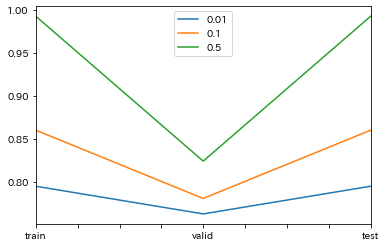

In [282]:
pd.DataFrame(ret).plot(kind='line')
plt.plot()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [284]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
param_grid = {'C': [0.5, 0.7]}
lr_grid = GridSearchCV(estimator=LogisticRegression(random_state=0),
                 param_grid = param_grid,   
                 scoring="accuracy",  #metrics
                 cv = 3,              #cross-validation
                 n_jobs = 1)          #number of core
